In [87]:
from typing import Any, Union
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob

# sns.set()
sns.set_theme()
# sns.set_style("white")
sns.set_style("whitegrid")
# sns.set_style("ticks")
sns.set_context("paper")

In [88]:
# Source: https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'neurips':
        width_pt = 397.48499
    elif width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [89]:
def load_train_results(filepath: Union[str, Path]) -> tuple[list, dict[str, Any]]:
    """Loads training results from JSON file."""
    with open(str(filepath), 'r') as f:
        d = json.load(f)
    return d['reward'], d['metrics']

In [90]:
def plot_with_errorbar(ax, data, label, color, plot_method: str = 'mean', error_method: str = 'std', plot_error: bool = True, plot_kwargs: dict = {}, fill_kwargs: dict = {}, **kwargs):
    
    ###
    # Method to highlight the main plot data.
    ###
    y = data
    
    # Plots the average run value at each epoch.
    if plot_method == 'mean':
        y = np.mean(data, axis=0) # (3000,)
        
    elif plot_method == 'mean-rolling':
        df = pd.DataFrame(np.mean(data, axis=0))
        y = df.rolling(10).mean().to_numpy().flatten()
    
    # Plots the run with the maximum average value over the last `n` epochs.
    elif plot_method.startswith('max-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_max = np.argmax(avg_last_n)
        y = data[idx_max] # Plot data is the index of the max.
        
    # Plots the run with the minimum average value over the last `n` epochs.
    elif plot_method.startswith('min-'):
        n = int(plot_method.split('-')[-1])
        avg_last_n = np.mean(data[:,-n:], axis=1)
        idx_min = np.argmin(avg_last_n)
        y = data[idx_min] # Plot data is the index of the min.
    
    else:
        raise ValueError(f"Unsupported plot highlight {plot_method}")
    
    ###
    # Method to produce the shaded error regions.
    ###
    if plot_error:
    
        # Shaded region is +/- standard deviation from the designated `y`-value.
        if error_method.startswith('std') and 'rolling' not in error_method:
            y_std = np.std(data, axis=0)# (3000,)
            n = 1 # Default is 1 std above/below the data.
            if '-' in error_method: # Pull `n` value from method type.
                n = int(error_method.split('-')[-1])
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'std-rolling':
            y_std = pd.DataFrame(y).rolling(10).std().to_numpy().flatten()
            n = 1 # Default is 1 std above/below the data.
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y - y_std, y+y_std, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        # Shaded region is minimum/maximum values at each epoch.
        elif error_method == 'minmax':
            y_min = np.min(data, axis=0) # (3000,)
            y_max = np.max(data, axis=0)# (3000,)
            x = np.arange(data.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
            
        elif error_method == 'minmax-rolling':
            y_min = pd.DataFrame(np.min(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            y_max = pd.DataFrame(np.max(data, axis=0)).rolling(10).mean().to_numpy().flatten() # (3000,)
            x = np.arange(y.shape[-1])
            ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
            # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))
            ax.fill_between(x, y_min, y_max, color=color, **(dict(alpha=0.2, linewidth=0.2) | fill_kwargs))
        
        else:
            raise ValueError(f"Unsupported error method {error_method}")
    
    else:
        x = np.arange(data.shape[-1])
        ax.plot(x, y, '-', **(dict(linewidth=0.2, label=label, color=color) | plot_kwargs))
        # ax.scatter(x, y, **(dict(label=label, color=color) | plot_kwargs))



In [91]:
for item in sns.color_palette():
    print(list(item))

[0.2980392156862745, 0.4470588235294118, 0.6901960784313725]
[0.8666666666666667, 0.5176470588235295, 0.3215686274509804]
[0.3333333333333333, 0.6588235294117647, 0.40784313725490196]
[0.7686274509803922, 0.3058823529411765, 0.3215686274509804]
[0.5058823529411764, 0.4470588235294118, 0.7019607843137254]
[0.5764705882352941, 0.47058823529411764, 0.3764705882352941]
[0.8549019607843137, 0.5450980392156862, 0.7647058823529411]
[0.5490196078431373, 0.5490196078431373, 0.5490196078431373]
[0.8, 0.7254901960784313, 0.4549019607843137]
[0.39215686274509803, 0.7098039215686275, 0.803921568627451]


In [92]:
set_size('neurips')

(5.499999861629998, 3.399186852607058)

Figure config loaded: figures.fig_maa2c_pomdp


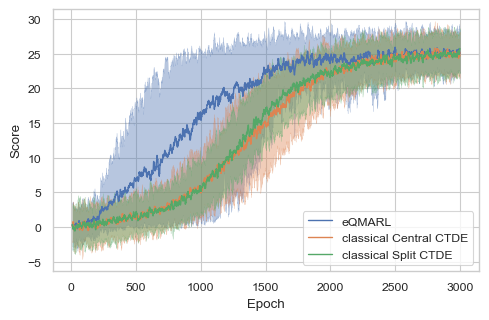

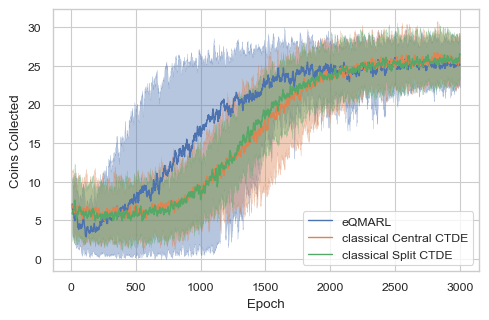

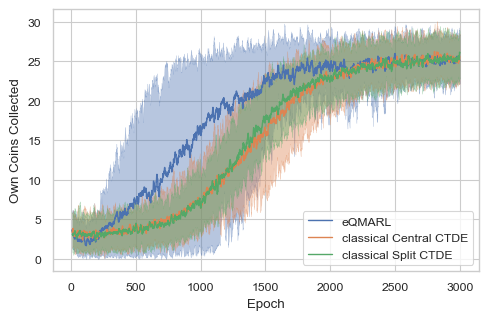

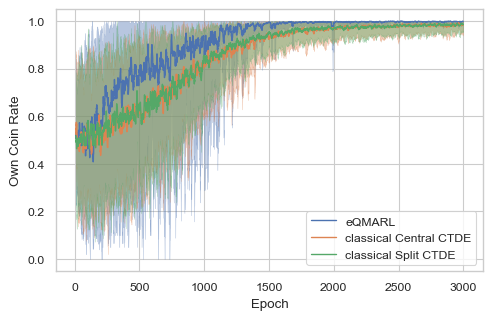

In [95]:
import sys
sys.path.append('../') # Use parent dir.

# fig_to_load = 'fig_maa2c_mdp'
fig_to_load = 'fig_maa2c_pomdp'
# fig_to_load = 'fig_maa2c_mdp_entanglement_compare'
# fig_to_load = 'fig_maa2c_mdp_entanglement_compare_focus'


import importlib
mod_name = f"figures.{fig_to_load}"
if mod_name in sys.modules:
    del sys.modules[mod_name]
mod = importlib.import_module(mod_name)
figures, series = mod.figures, mod.series
# print(m.figures, m.series)
print(f"Figure config loaded: {mod_name}")



# Collect all data from all series and put into frames.
series_df: dict[str, pd.DataFrame] = {}
for series_kwargs in series:
    key, blob = series_kwargs['key'], series_kwargs['blob']
    
    files = glob.glob(str(Path(blob).expanduser()))
    session_reward_history = []
    session_metrics_history = []
    for f in files:
        reward_history, metrics_history = load_train_results(str(f))
        session_reward_history.append(reward_history)
        session_metrics_history.append(metrics_history)
        
    # Reshape to proper matrix.
    session_reward_history = session_reward_history
    session_reward_history = np.array(session_reward_history)
    
    df = pd.DataFrame(session_metrics_history)
    series_df[key] = df



# Generate figures.
for fig_kwargs in figures:
    
    if fig_kwargs['type'] == 'subplots':
        # fig, ax = plt.subplots(**fig_kwargs['kwargs'], subplot_kw=dict(projection='3d'))
        fig, ax = plt.subplots(**fig_kwargs['kwargs'])
        if not isinstance(ax, list):
            ax = [ax]
        ax = np.array(ax).flatten()
        
        for ax_idx, ax_kwargs in enumerate(fig_kwargs['ax']):
            for j, series_kwargs in enumerate(ax_kwargs['series']):
                df = series_df[series_kwargs['key']]
                df_arr = np.array(df.values.tolist())
                i = list(df.columns).index(ax_kwargs['metric']) # Index of metric key within frame column.
                plot_with_errorbar(ax[ax_idx], df_arr[:,i,:], **series_kwargs)
            
            # Turn on legend.
            ax[ax_idx].legend(**ax_kwargs['legend_kwargs'])
            
            # Set axis title.
            title = None
            if 'title' in ax_kwargs:
                title = ax_kwargs['title']
            ax[ax_idx].set_title(title)
            
            # Set axis X-label.
            if 'xlabel' in ax_kwargs:
                ax[ax_idx].set_xlabel(ax_kwargs['xlabel'])
            
            # Set axis Y-label.
            if 'ylabel' in ax_kwargs:
                ax[ax_idx].set_ylabel(ax_kwargs['ylabel'])
        
        # sns.despine(fig)